In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import sympy

import def_all_CRNs as CRNs
from dae_finder import (
        AlgModelFinder,
        PolyFeatureMatrix,
        add_noise_to_df,
        get_refined_lib,
        sequentialThLin,
        smooth_data,
)

### Discovery of Algebraic Relationships

In [45]:
num_points = 1000
noise_perc = 0

In [46]:
# 1) Make data
clean_data = CRNs.make_CRN3(5, num_points)
clean_df = pd.DataFrame(clean_data, columns=['t', 'A', 'B', 'C', 'D', 'F', 'E1', 'AE1', 'E2', 'BE2', 'CE2', 'E3', 'BE3', 'E4', 'DE4'])

data_matrix_df_list = [clean_df.iloc[i:i+num_points].reset_index(drop=True) for i in range(0, len(clean_df), num_points)]

tSolve = list(data_matrix_df_list[0]['t'])
num_time_points = len(tSolve)

# 2) Noise data
for ind, data_matrix_ in enumerate(data_matrix_df_list):
        t_exact = data_matrix_["t"]
        noisy_data_df = add_noise_to_df(data_matrix_, noise_perc=noise_perc, random_seed=8) # Use trial as RNG seed
        noisy_data_df["t"] = t_exact
        data_matrix_df_list[ind] = noisy_data_df

data_matrix_df_appended = pd.concat(data_matrix_df_list, ignore_index=True)

data_matrix_features = data_matrix_df_list[0].columns

# 3) Smooth noisy data
data_matrix_smooth_df_list = [
    smooth_data(data_matrix[:num_points],
                domain_var="t",
                smooth_method ="SG",
                noise_perc=0.1,
                derr_order=1,
                polyorder=2,
                window_smooth=None)[10:-10] #trimming zero derivatives near end points
    for data_matrix in data_matrix_df_list]

if len(data_matrix_smooth_df_list) == 1:
        data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0].reset_index(drop=True)
else:
        data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)

data_matrix_df_new= data_matrix_df_smooth_appended[['A', 'B', 'C', 'D', 'F', 'E1', 'AE1', 'E2', 'BE2', 'CE2', 'E3', 'BE3', 'E4', 'DE4']]


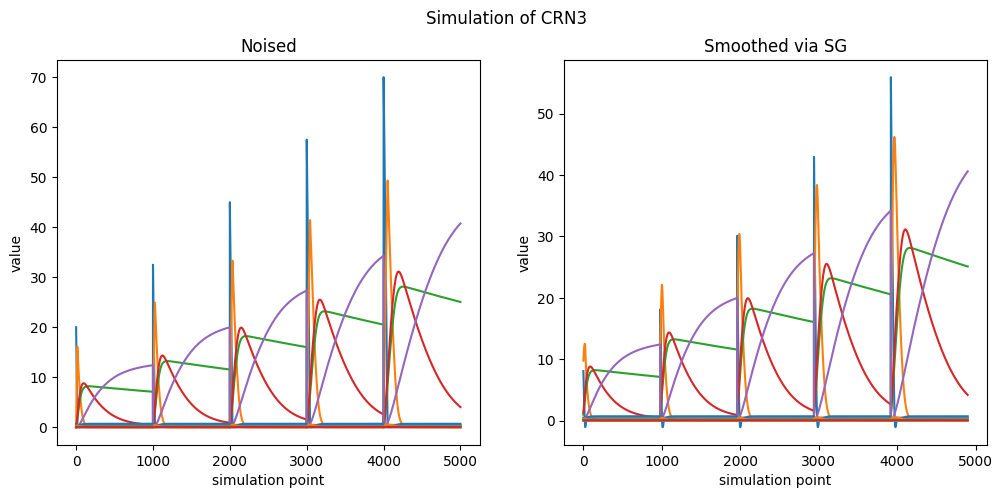

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

axes[0].plot(data_matrix_df_appended.drop('t', axis=1))
axes[0].set_title("Noised")

axes[1].plot(data_matrix_df_new)
axes[1].set_title("Smoothed via SG")

axes[0].set_xlabel("simulation point")
axes[1].set_xlabel("simulation point")

axes[0].set_ylabel("value")
axes[1].set_ylabel("value")

# Shared title
fig.suptitle("Simulation of CRN3")

# Show the plot
plt.show()

In [7]:
# 4) Make lib
poly_degree = 2

poly_feature_ob = PolyFeatureMatrix(poly_degree)
candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_new)
candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)

print("Degree of library: {}".format(poly_degree))
print("# terms in the library: {}".format(candidate_lib_full.shape[1]))
print("Full candidate library has the following features: {}".format(list(candidate_lib_full.columns)))

Degree of library: 2
# terms in the library: 119
Full candidate library has the following features: ['A', 'B', 'C', 'D', 'F', 'E1', 'AE1', 'E2', 'BE2', 'CE2', 'E3', 'BE3', 'E4', 'DE4', 'A^2', 'A B', 'A C', 'A D', 'A F', 'A E1', 'A AE1', 'A E2', 'A BE2', 'A CE2', 'A E3', 'A BE3', 'A E4', 'A DE4', 'B^2', 'B C', 'B D', 'B F', 'B E1', 'B AE1', 'B E2', 'B BE2', 'B CE2', 'B E3', 'B BE3', 'B E4', 'B DE4', 'C^2', 'C D', 'C F', 'C E1', 'C AE1', 'C E2', 'C BE2', 'C CE2', 'C E3', 'C BE3', 'C E4', 'C DE4', 'D^2', 'D F', 'D E1', 'D AE1', 'D E2', 'D BE2', 'D CE2', 'D E3', 'D BE3', 'D E4', 'D DE4', 'F^2', 'F E1', 'F AE1', 'F E2', 'F BE2', 'F CE2', 'F E3', 'F BE3', 'F E4', 'F DE4', 'E1^2', 'E1 AE1', 'E1 E2', 'E1 BE2', 'E1 CE2', 'E1 E3', 'E1 BE3', 'E1 E4', 'E1 DE4', 'AE1^2', 'AE1 E2', 'AE1 BE2', 'AE1 CE2', 'AE1 E3', 'AE1 BE3', 'AE1 E4', 'AE1 DE4', 'E2^2', 'E2 BE2', 'E2 CE2', 'E2 E3', 'E2 BE3', 'E2 E4', 'E2 DE4', 'BE2^2', 'BE2 CE2', 'BE2 E3', 'BE2 BE3', 'BE2 E4', 'BE2 DE4', 'CE2^2', 'CE2 E3', 'CE2 BE3',

In [8]:
# 5) Make feats
feat_list = ['A', 'B', 'C', 'D', 'F', 'E1', 'AE1', 'E2', 'BE2', 'CE2', 'E3', 'BE3', 'E4', 'DE4']
feat_list_str = ", ".join(feat_list)
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")

In [9]:
# 6) Find first rel (mass conservation)
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)
algebraic_model_th.fit(data_matrix_df_new, scale_columns= True)
best_model = algebraic_model_th.best_models(1)

best_lhs = [best_model.columns[0]]
best_rhs = best_model.index[best_model.iloc[:, 0] != 0][:-1].tolist()
best_lhs + best_rhs

Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations


['BE2', 'E2', 'CE2']

In [10]:
# 6) Find second rel (mass conservation)
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)
algebraic_model_th.fit(data_matrix_df_new.drop('E2', axis=1), scale_columns= True)
best_model = algebraic_model_th.best_models(1)

best_lhs = [best_model.columns[0]]
best_rhs = best_model.index[best_model.iloc[:, 0] != 0][:-1].tolist()
best_lhs + best_rhs

Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations


['E1', 'AE1']

In [11]:
# 6) Find third rel (mass conservation)
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)
algebraic_model_th.fit(data_matrix_df_new.drop(['E2', 'E1'], axis=1), scale_columns= True)
best_model = algebraic_model_th.best_models(1)

best_lhs = [best_model.columns[0]]
best_rhs = best_model.index[best_model.iloc[:, 0] != 0][:-1].tolist()
best_lhs + best_rhs

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 0 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations


['E3', 'BE3']

In [12]:
# 6) Find fourth rel (mass conservation)
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)
algebraic_model_th.fit(data_matrix_df_new.drop(['E2', 'E1', 'E3'], axis=1), scale_columns= True)
best_model = algebraic_model_th.best_models(1)

best_lhs = [best_model.columns[0]]
best_rhs = best_model.index[best_model.iloc[:, 0] != 0][:-1].tolist()
best_lhs + best_rhs

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 0 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations


['E4', 'DE4']

In [13]:
# 7) Remove first, second rels (mass conservation of enz)
features_to_remove, refined_candid_lib = get_refined_lib({E2, E1, E3, E4}, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)
print("Terms removed library: {}".format(list(features_to_remove)))
print("# terms in the library: {}".format(refined_candid_lib.shape[1]))
print("Candidate library has the following features: {}".format(list(refined_candid_lib.columns)))

Terms removed library: ['A E4', 'E2 CE2', 'C E1', 'E3 E4', 'B E3', 'E3 DE4', 'B E1', 'A E3', 'E1', 'E1 E2', 'E2 E3', 'E2 DE4', 'CE2 E4', 'C E4', 'E2', 'E4 DE4', 'E1 AE1', 'F E3', 'D E3', 'BE2 E4', 'A E2', 'E1 DE4', 'D E4', 'E3^2', 'E1 E3', 'D E2', 'E4^2', 'E1^2', 'E3 BE3', 'AE1 E3', 'E1 BE3', 'AE1 E4', 'CE2 E3', 'E1 CE2', 'F E2', 'BE3 E4', 'E1 BE2', 'A E1', 'E4', 'B E2', 'F E4', 'BE2 E3', 'E2 BE3', 'E2 E4', 'AE1 E2', 'D E1', 'B E4', 'E2 BE2', 'F E1', 'E3', 'E2^2', 'C E2', 'C E3', 'E1 E4']
# terms in the library: 65
Candidate library has the following features: ['A', 'B', 'C', 'D', 'F', 'AE1', 'BE2', 'CE2', 'BE3', 'DE4', 'A^2', 'A B', 'A C', 'A D', 'A F', 'A AE1', 'A BE2', 'A CE2', 'A BE3', 'A DE4', 'B^2', 'B C', 'B D', 'B F', 'B AE1', 'B BE2', 'B CE2', 'B BE3', 'B DE4', 'C^2', 'C D', 'C F', 'C AE1', 'C BE2', 'C CE2', 'C BE3', 'C DE4', 'D^2', 'D F', 'D AE1', 'D BE2', 'D CE2', 'D BE3', 'D DE4', 'F^2', 'F AE1', 'F BE2', 'F CE2', 'F BE3', 'F DE4', 'AE1^2', 'AE1 BE2', 'AE1 CE2', 'AE1 BE3', 

In [14]:
# 8) Search for QSSA
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)
algebraic_model_th.fit(refined_candid_lib, scale_columns= True)
best_model = algebraic_model_th.best_models(1)

best_lhs = [best_model.columns[0]]
best_rhs = best_model.index[best_model.iloc[:, 0] != 0][:-1].tolist()
best_lhs + best_rhs

Sequential threshold converged in 5 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 5 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 4 iterations
Sequential th

['BE2 BE3', 'BE2^2', 'BE3^2']

In [15]:
# 9) Remove second rel (mass conservation of other enz)
features_to_remove, refined_candid_lib = get_refined_lib({E2, E1, E3, E4, BE2*BE3}, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)
print("Terms removed library: {}".format(list(features_to_remove)))
print("# terms in the library: {}".format(refined_candid_lib.shape[1]))
print("Candidate library has the following features: {}".format(list(refined_candid_lib.columns)))

Terms removed library: ['A E4', 'C E1', 'E2 CE2', 'E3 E4', 'B E3', 'E3 DE4', 'B E1', 'A E3', 'E1', 'E1 E2', 'E2 E3', 'E2 DE4', 'CE2 E4', 'C E4', 'E2', 'E4 DE4', 'E1 AE1', 'F E3', 'D E3', 'BE2 E4', 'A E2', 'E1 DE4', 'D E4', 'E3^2', 'E1 E3', 'D E2', 'E4^2', 'E1^2', 'E3 BE3', 'AE1 E3', 'E1 BE3', 'AE1 E4', 'CE2 E3', 'E1 CE2', 'F E2', 'BE3 E4', 'E1 BE2', 'A E1', 'E4', 'E1 E4', 'B E2', 'F E4', 'BE2 E3', 'E2 BE3', 'E2 E4', 'AE1 E2', 'D E1', 'BE2 BE3', 'B E4', 'F E1', 'E3', 'E2^2', 'C E2', 'C E3', 'E2 BE2']
# terms in the library: 64
Candidate library has the following features: ['A', 'B', 'C', 'D', 'F', 'AE1', 'BE2', 'CE2', 'BE3', 'DE4', 'A^2', 'A B', 'A C', 'A D', 'A F', 'A AE1', 'A BE2', 'A CE2', 'A BE3', 'A DE4', 'B^2', 'B C', 'B D', 'B F', 'B AE1', 'B BE2', 'B CE2', 'B BE3', 'B DE4', 'C^2', 'C D', 'C F', 'C AE1', 'C BE2', 'C CE2', 'C BE3', 'C DE4', 'D^2', 'D F', 'D AE1', 'D BE2', 'D CE2', 'D BE3', 'D DE4', 'F^2', 'F AE1', 'F BE2', 'F CE2', 'F BE3', 'F DE4', 'AE1^2', 'AE1 BE2', 'AE1 CE2', 

In [120]:
# 10) Continue to remove; for plotting cond num + SVD
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)
algebraic_model_th.fit(refined_candid_lib, scale_columns= True)
best_model = algebraic_model_th.best_models(1)

best_lhs = [best_model.columns[0]]
best_rhs = best_model.index[best_model.iloc[:, 0] != 0][:-1].tolist()
best_lhs + best_rhs

Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 5 iterations
Sequential threshold converged in 6 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 5 iterations
Sequential th

['A BE2', 'A BE3']

In [16]:
features_to_remove, refined_candid_lib = get_refined_lib({E2, E1, E3, E4, BE2*BE3, A*BE2}, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)
print("Terms removed library: {}".format(list(features_to_remove)))
print("# terms in the library: {}".format(refined_candid_lib.shape[1]))
print("Candidate library has the following features: {}".format(list(refined_candid_lib.columns)))

Terms removed library: ['A E4', 'C E1', 'E2 CE2', 'E3 E4', 'B E3', 'E3 DE4', 'B E1', 'A E3', 'E1', 'E1 E2', 'E2 E3', 'E2 DE4', 'CE2 E4', 'C E4', 'E2', 'E4 DE4', 'E1 AE1', 'F E3', 'D E3', 'BE2 E4', 'A E2', 'E1 DE4', 'D E4', 'E3^2', 'E1 E3', 'D E2', 'E4^2', 'E1^2', 'E3 BE3', 'AE1 E3', 'E1 BE3', 'AE1 E4', 'CE2 E3', 'A BE2', 'E1 CE2', 'F E2', 'BE3 E4', 'E1 BE2', 'A E1', 'E4', 'E1 E4', 'B E2', 'F E4', 'BE2 E3', 'E2 BE3', 'E2 E4', 'AE1 E2', 'D E1', 'BE2 BE3', 'B E4', 'F E1', 'E3', 'E2^2', 'C E2', 'C E3', 'E2 BE2']
# terms in the library: 63
Candidate library has the following features: ['A', 'B', 'C', 'D', 'F', 'AE1', 'BE2', 'CE2', 'BE3', 'DE4', 'A^2', 'A B', 'A C', 'A D', 'A F', 'A AE1', 'A CE2', 'A BE3', 'A DE4', 'B^2', 'B C', 'B D', 'B F', 'B AE1', 'B BE2', 'B CE2', 'B BE3', 'B DE4', 'C^2', 'C D', 'C F', 'C AE1', 'C BE2', 'C CE2', 'C BE3', 'C DE4', 'D^2', 'D F', 'D AE1', 'D BE2', 'D CE2', 'D BE3', 'D DE4', 'F^2', 'F AE1', 'F BE2', 'F CE2', 'F BE3', 'F DE4', 'AE1^2', 'AE1 BE2', 'AE1 CE2', 

In [17]:
# 10 cont.) Continue to remove; for plotting cond num + SVD
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)
algebraic_model_th.fit(refined_candid_lib, scale_columns= True)
best_model = algebraic_model_th.best_models(1)

best_lhs = [best_model.columns[0]]
best_rhs = best_model.index[best_model.iloc[:, 0] != 0][:-1].tolist()
best_lhs + best_rhs

Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 5 iterations
Sequential threshold converged in 2 iterations
Sequential th

['A D', 'A C', 'A DE4']

In [18]:
features_to_remove, refined_candid_lib = get_refined_lib({E2, E1, E3, E4, BE2*BE3, A*BE2, A*DE4}, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)
print("Terms removed library: {}".format(list(features_to_remove)))
print("# terms in the library: {}".format(refined_candid_lib.shape[1]))
print("Candidate library has the following features: {}".format(list(refined_candid_lib.columns)))

Terms removed library: ['A E4', 'C E1', 'E2 CE2', 'E3 E4', 'B E3', 'E3 DE4', 'B E1', 'A E3', 'E1', 'E1 E2', 'E2 E3', 'E2 DE4', 'CE2 E4', 'C E4', 'E2', 'E4 DE4', 'E1 AE1', 'F E3', 'D E3', 'BE2 E4', 'A E2', 'E1 DE4', 'D E4', 'E3^2', 'E1 E3', 'D E2', 'E4^2', 'E1^2', 'E3 BE3', 'AE1 E3', 'E1 BE3', 'AE1 E4', 'A DE4', 'CE2 E3', 'A BE2', 'E1 CE2', 'F E2', 'BE3 E4', 'E1 BE2', 'A E1', 'E4', 'E1 E4', 'B E2', 'F E4', 'BE2 E3', 'E2 BE3', 'E2 E4', 'AE1 E2', 'D E1', 'BE2 BE3', 'B E4', 'F E1', 'E3', 'E2^2', 'C E2', 'C E3', 'E2 BE2']
# terms in the library: 62
Candidate library has the following features: ['A', 'B', 'C', 'D', 'F', 'AE1', 'BE2', 'CE2', 'BE3', 'DE4', 'A^2', 'A B', 'A C', 'A D', 'A F', 'A AE1', 'A CE2', 'A BE3', 'B^2', 'B C', 'B D', 'B F', 'B AE1', 'B BE2', 'B CE2', 'B BE3', 'B DE4', 'C^2', 'C D', 'C F', 'C AE1', 'C BE2', 'C CE2', 'C BE3', 'C DE4', 'D^2', 'D F', 'D AE1', 'D BE2', 'D CE2', 'D BE3', 'D DE4', 'F^2', 'F AE1', 'F BE2', 'F CE2', 'F BE3', 'F DE4', 'AE1^2', 'AE1 BE2', 'AE1 CE2', 

In [19]:
# 10 cont.) Continue to remove; for plotting cond num + SVD
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)
algebraic_model_th.fit(refined_candid_lib, scale_columns= True)
best_model = algebraic_model_th.best_models(1)

best_lhs = [best_model.columns[0]]
best_rhs = best_model.index[best_model.iloc[:, 0] != 0][:-1].tolist()
best_lhs + best_rhs

Sequential threshold converged in 4 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 8 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 6 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 5 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential th

['D AE1', 'C AE1', 'AE1 DE4']

In [20]:
features_to_remove, refined_candid_lib = get_refined_lib({E2, E1, E3, E4, BE2*BE3, A*BE2, A*DE4, C*AE1}, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)
print("Terms removed library: {}".format(list(features_to_remove)))
print("# terms in the library: {}".format(refined_candid_lib.shape[1]))
print("Candidate library has the following features: {}".format(list(refined_candid_lib.columns)))

Terms removed library: ['A E4', 'C E1', 'E2 CE2', 'E3 E4', 'B E3', 'E3 DE4', 'B E1', 'A E3', 'E1', 'C AE1', 'E1 E2', 'E2 E3', 'E2 DE4', 'CE2 E4', 'C E4', 'E2', 'E4 DE4', 'E1 AE1', 'F E3', 'D E3', 'BE2 E4', 'A E2', 'E1 DE4', 'D E4', 'E3^2', 'E1 E3', 'D E2', 'E4^2', 'E1^2', 'E3 BE3', 'AE1 E3', 'E1 BE3', 'AE1 E4', 'A DE4', 'CE2 E3', 'A BE2', 'E1 CE2', 'F E2', 'BE3 E4', 'E1 BE2', 'A E1', 'E4', 'E1 E4', 'B E2', 'F E4', 'BE2 E3', 'E2 BE3', 'E2 E4', 'AE1 E2', 'D E1', 'BE2 BE3', 'B E4', 'F E1', 'E3', 'E2^2', 'C E2', 'C E3', 'E2 BE2']
# terms in the library: 61
Candidate library has the following features: ['A', 'B', 'C', 'D', 'F', 'AE1', 'BE2', 'CE2', 'BE3', 'DE4', 'A^2', 'A B', 'A C', 'A D', 'A F', 'A AE1', 'A CE2', 'A BE3', 'B^2', 'B C', 'B D', 'B F', 'B AE1', 'B BE2', 'B CE2', 'B BE3', 'B DE4', 'C^2', 'C D', 'C F', 'C BE2', 'C CE2', 'C BE3', 'C DE4', 'D^2', 'D F', 'D AE1', 'D BE2', 'D CE2', 'D BE3', 'D DE4', 'F^2', 'F AE1', 'F BE2', 'F CE2', 'F BE3', 'F DE4', 'AE1^2', 'AE1 BE2', 'AE1 CE2', 

In [21]:
# 10 cont.) Continue to remove; for plotting cond num + SVD
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)
algebraic_model_th.fit(refined_candid_lib, scale_columns= True)
best_model = algebraic_model_th.best_models(1)

best_lhs = [best_model.columns[0]]
best_rhs = best_model.index[best_model.iloc[:, 0] != 0][:-1].tolist()
best_lhs + best_rhs

Sequential threshold converged in 4 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 5 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 6 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 5 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential th

['D', 'DE4', 'D DE4']

In [22]:
features_to_remove, refined_candid_lib = get_refined_lib({E2, E1, E3, E4, BE2*BE3, A*BE2, A*DE4, C*AE1, D*DE4}, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)
print("Terms removed library: {}".format(list(features_to_remove)))
print("# terms in the library: {}".format(refined_candid_lib.shape[1]))
print("Candidate library has the following features: {}".format(list(refined_candid_lib.columns)))

Terms removed library: ['A E4', 'C E1', 'E2 CE2', 'E3 E4', 'B E3', 'E3 DE4', 'B E1', 'A E3', 'E1', 'C AE1', 'E1 E2', 'E2 E3', 'E2 DE4', 'CE2 E4', 'C E4', 'E2', 'E4 DE4', 'E1 AE1', 'F E3', 'D E3', 'BE2 E4', 'A E2', 'E1 DE4', 'D E4', 'E3^2', 'E1 E3', 'D E2', 'D DE4', 'E4^2', 'E1^2', 'E3 BE3', 'AE1 E3', 'E1 BE3', 'AE1 E4', 'A DE4', 'CE2 E3', 'A BE2', 'E1 CE2', 'F E2', 'BE3 E4', 'E1 BE2', 'A E1', 'E4', 'E1 E4', 'B E2', 'F E4', 'BE2 E3', 'E2 BE3', 'E2 E4', 'AE1 E2', 'D E1', 'BE2 BE3', 'B E4', 'F E1', 'E3', 'E2^2', 'C E2', 'C E3', 'E2 BE2']
# terms in the library: 60
Candidate library has the following features: ['A', 'B', 'C', 'D', 'F', 'AE1', 'BE2', 'CE2', 'BE3', 'DE4', 'A^2', 'A B', 'A C', 'A D', 'A F', 'A AE1', 'A CE2', 'A BE3', 'B^2', 'B C', 'B D', 'B F', 'B AE1', 'B BE2', 'B CE2', 'B BE3', 'B DE4', 'C^2', 'C D', 'C F', 'C BE2', 'C CE2', 'C BE3', 'C DE4', 'D^2', 'D F', 'D AE1', 'D BE2', 'D CE2', 'D BE3', 'F^2', 'F AE1', 'F BE2', 'F CE2', 'F BE3', 'F DE4', 'AE1^2', 'AE1 BE2', 'AE1 CE2', 

In [23]:
# 10 cont.) Continue to remove; for plotting cond num + SVD
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)
algebraic_model_th.fit(refined_candid_lib, scale_columns= True)
best_model = algebraic_model_th.best_models(1)

best_lhs = [best_model.columns[0]]
best_rhs = best_model.index[best_model.iloc[:, 0] != 0][:-1].tolist()
best_lhs + best_rhs

Sequential threshold converged in 4 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 6 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 6 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 5 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential th

['D^2', 'C^2', 'C D', 'D F', 'D CE2', 'F CE2', 'CE2 DE4']

In [24]:
features_to_remove, refined_candid_lib = get_refined_lib({E2, E1, E3, E4, BE2*BE3, A*BE2, A*DE4, C*AE1, D*DE4, D**2}, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)
print("Terms removed library: {}".format(list(features_to_remove)))
print("# terms in the library: {}".format(refined_candid_lib.shape[1]))
print("Candidate library has the following features: {}".format(list(refined_candid_lib.columns)))

Terms removed library: ['A E4', 'C E1', 'E2 CE2', 'E3 E4', 'B E3', 'E3 DE4', 'B E1', 'A E3', 'E1', 'C AE1', 'E1 E2', 'E2 E3', 'E2 DE4', 'CE2 E4', 'C E4', 'E2', 'E4 DE4', 'E1 AE1', 'F E3', 'D E3', 'BE2 E4', 'A E2', 'E1 DE4', 'D E4', 'E3^2', 'E1 E3', 'D E2', 'D DE4', 'E4^2', 'E1^2', 'E3 BE3', 'AE1 E3', 'E1 BE3', 'AE1 E4', 'A DE4', 'CE2 E3', 'A BE2', 'E1 CE2', 'F E2', 'BE3 E4', 'E1 BE2', 'A E1', 'E4', 'E1 E4', 'B E2', 'F E4', 'BE2 E3', 'E2 BE3', 'D^2', 'E2 E4', 'AE1 E2', 'D E1', 'BE2 BE3', 'B E4', 'F E1', 'E3', 'E2^2', 'C E2', 'C E3', 'E2 BE2']
# terms in the library: 59
Candidate library has the following features: ['A', 'B', 'C', 'D', 'F', 'AE1', 'BE2', 'CE2', 'BE3', 'DE4', 'A^2', 'A B', 'A C', 'A D', 'A F', 'A AE1', 'A CE2', 'A BE3', 'B^2', 'B C', 'B D', 'B F', 'B AE1', 'B BE2', 'B CE2', 'B BE3', 'B DE4', 'C^2', 'C D', 'C F', 'C BE2', 'C CE2', 'C BE3', 'C DE4', 'D F', 'D AE1', 'D BE2', 'D CE2', 'D BE3', 'F^2', 'F AE1', 'F BE2', 'F CE2', 'F BE3', 'F DE4', 'AE1^2', 'AE1 BE2', 'AE1 CE2', 

In [25]:
# 10 cont.) Continue to remove; for plotting cond num + SVD
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)
algebraic_model_th.fit(refined_candid_lib, scale_columns= True)
best_model = algebraic_model_th.best_models(1)

best_lhs = [best_model.columns[0]]
best_rhs = best_model.index[best_model.iloc[:, 0] != 0][:-1].tolist()
best_lhs + best_rhs

Sequential threshold converged in 4 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 6 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 6 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 6 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 5 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential th

['D BE2', 'C BE2', 'C BE3', 'D BE3']

In [26]:
features_to_remove, refined_candid_lib = get_refined_lib({E2, E1, E3, E4, BE2*BE3, A*BE2, A*DE4, C*AE1, D*DE4, D**2, C*BE2}, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)
print("Terms removed library: {}".format(list(features_to_remove)))
print("# terms in the library: {}".format(refined_candid_lib.shape[1]))
print("Candidate library has the following features: {}".format(list(refined_candid_lib.columns)))

Terms removed library: ['A E4', 'C E1', 'E2 CE2', 'E3 E4', 'B E3', 'E3 DE4', 'B E1', 'A E3', 'E1', 'C AE1', 'E1 E2', 'E2 E3', 'E2 DE4', 'CE2 E4', 'C E4', 'E2', 'E4 DE4', 'E1 AE1', 'F E3', 'D E3', 'BE2 E4', 'A E2', 'E1 DE4', 'D E4', 'E3^2', 'E1 E3', 'D E2', 'D DE4', 'E4^2', 'E1^2', 'E3 BE3', 'AE1 E3', 'E1 BE3', 'AE1 E4', 'A DE4', 'CE2 E3', 'A BE2', 'E1 CE2', 'F E2', 'BE3 E4', 'E1 BE2', 'A E1', 'E4', 'E1 E4', 'B E2', 'F E4', 'C BE2', 'BE2 E3', 'E2 BE3', 'D^2', 'E2 E4', 'AE1 E2', 'D E1', 'BE2 BE3', 'B E4', 'F E1', 'E3', 'E2^2', 'C E2', 'C E3', 'E2 BE2']
# terms in the library: 58
Candidate library has the following features: ['A', 'B', 'C', 'D', 'F', 'AE1', 'BE2', 'CE2', 'BE3', 'DE4', 'A^2', 'A B', 'A C', 'A D', 'A F', 'A AE1', 'A CE2', 'A BE3', 'B^2', 'B C', 'B D', 'B F', 'B AE1', 'B BE2', 'B CE2', 'B BE3', 'B DE4', 'C^2', 'C D', 'C F', 'C CE2', 'C BE3', 'C DE4', 'D F', 'D AE1', 'D BE2', 'D CE2', 'D BE3', 'F^2', 'F AE1', 'F BE2', 'F CE2', 'F BE3', 'F DE4', 'AE1^2', 'AE1 BE2', 'AE1 CE2', 

In [27]:
# 10 cont.) Continue to remove; for plotting cond num + SVD
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)
algebraic_model_th.fit(refined_candid_lib, scale_columns= True)
best_model = algebraic_model_th.best_models(1)

best_lhs = [best_model.columns[0]]
best_rhs = best_model.index[best_model.iloc[:, 0] != 0][:-1].tolist()
best_lhs + best_rhs

Sequential threshold converged in 4 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 7 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 5 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 5 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential th

['AE1 BE2', 'AE1 BE3']

In [28]:
features_to_remove, refined_candid_lib = get_refined_lib({E2, E1, E3, E4, BE2*BE3, A*BE2, A*DE4, C*AE1, D*DE4, D**2, C*BE2, AE1*BE2}, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)
print("Terms removed library: {}".format(list(features_to_remove)))
print("# terms in the library: {}".format(refined_candid_lib.shape[1]))
print("Candidate library has the following features: {}".format(list(refined_candid_lib.columns)))

Terms removed library: ['A E4', 'C E1', 'E2 CE2', 'E3 E4', 'B E3', 'E3 DE4', 'B E1', 'A E3', 'E1', 'C AE1', 'E1 E2', 'E2 E3', 'E2 DE4', 'CE2 E4', 'C E4', 'E2', 'E4 DE4', 'E1 AE1', 'F E3', 'D E3', 'BE2 E4', 'A E2', 'E1 DE4', 'D E4', 'E3^2', 'E1 E3', 'D E2', 'D DE4', 'E4^2', 'E1^2', 'AE1 BE2', 'E3 BE3', 'AE1 E3', 'E1 BE3', 'AE1 E4', 'A DE4', 'CE2 E3', 'A BE2', 'E1 CE2', 'F E2', 'BE3 E4', 'E1 BE2', 'A E1', 'E4', 'E1 E4', 'B E2', 'F E4', 'C BE2', 'BE2 E3', 'E2 BE3', 'D^2', 'E2 E4', 'AE1 E2', 'D E1', 'BE2 BE3', 'B E4', 'F E1', 'E3', 'E2^2', 'C E2', 'C E3', 'E2 BE2']
# terms in the library: 57
Candidate library has the following features: ['A', 'B', 'C', 'D', 'F', 'AE1', 'BE2', 'CE2', 'BE3', 'DE4', 'A^2', 'A B', 'A C', 'A D', 'A F', 'A AE1', 'A CE2', 'A BE3', 'B^2', 'B C', 'B D', 'B F', 'B AE1', 'B BE2', 'B CE2', 'B BE3', 'B DE4', 'C^2', 'C D', 'C F', 'C CE2', 'C BE3', 'C DE4', 'D F', 'D AE1', 'D BE2', 'D CE2', 'D BE3', 'F^2', 'F AE1', 'F BE2', 'F CE2', 'F BE3', 'F DE4', 'AE1^2', 'AE1 CE2', 

In [29]:
# 10 cont.) Continue to remove; for plotting cond num + SVD
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)
algebraic_model_th.fit(refined_candid_lib, scale_columns= True)
best_model = algebraic_model_th.best_models(1)

best_lhs = [best_model.columns[0]]
best_rhs = best_model.index[best_model.iloc[:, 0] != 0][:-1].tolist()
best_lhs + best_rhs

Sequential threshold converged in 4 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 7 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 5 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 5 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential th

['A B',
 'A',
 'A C',
 'A D',
 'A F',
 'A AE1',
 'A CE2',
 'A BE3',
 'B AE1',
 'AE1 CE2',
 'AE1 BE3',
 'AE1 DE4']

In [31]:
features_to_remove, refined_candid_lib = get_refined_lib({E2, E1, E3, E4, BE2*BE3, A*BE2, A*DE4, C*AE1, D*DE4, D**2, C*BE2, AE1*BE2, B*AE1}, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)
print("Terms removed library: {}".format(list(features_to_remove)))
print("# terms in the library: {}".format(refined_candid_lib.shape[1]))
print("Candidate library has the following features: {}".format(list(refined_candid_lib.columns)))

Terms removed library: ['A E4', 'C E1', 'E2 CE2', 'E3 E4', 'B E3', 'E3 DE4', 'B E1', 'A E3', 'E1', 'C AE1', 'E1 E2', 'E2 E3', 'E2 DE4', 'CE2 E4', 'C E4', 'E2', 'E4 DE4', 'E1 AE1', 'F E3', 'D E3', 'BE2 E4', 'A E2', 'E1 DE4', 'D E4', 'E3^2', 'E1 E3', 'D E2', 'D DE4', 'E4^2', 'E1^2', 'AE1 BE2', 'E3 BE3', 'AE1 E3', 'E1 BE3', 'AE1 E4', 'A DE4', 'CE2 E3', 'A BE2', 'E1 CE2', 'B AE1', 'F E2', 'BE3 E4', 'E1 BE2', 'A E1', 'E4', 'E1 E4', 'B E2', 'F E4', 'C BE2', 'BE2 E3', 'E2 BE3', 'D^2', 'E2 E4', 'AE1 E2', 'D E1', 'BE2 BE3', 'B E4', 'F E1', 'E3', 'E2^2', 'C E2', 'C E3', 'E2 BE2']
# terms in the library: 56
Candidate library has the following features: ['A', 'B', 'C', 'D', 'F', 'AE1', 'BE2', 'CE2', 'BE3', 'DE4', 'A^2', 'A B', 'A C', 'A D', 'A F', 'A AE1', 'A CE2', 'A BE3', 'B^2', 'B C', 'B D', 'B F', 'B BE2', 'B CE2', 'B BE3', 'B DE4', 'C^2', 'C D', 'C F', 'C CE2', 'C BE3', 'C DE4', 'D F', 'D AE1', 'D BE2', 'D CE2', 'D BE3', 'F^2', 'F AE1', 'F BE2', 'F CE2', 'F BE3', 'F DE4', 'AE1^2', 'AE1 CE2', 

In [32]:
# 10 cont.) Continue to remove; for plotting cond num + SVD
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)
algebraic_model_th.fit(refined_candid_lib, scale_columns= True)
best_model = algebraic_model_th.best_models(1)

best_lhs = [best_model.columns[0]]
best_rhs = best_model.index[best_model.iloc[:, 0] != 0][:-1].tolist()
best_lhs + best_rhs

Sequential threshold converged in 4 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 7 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 5 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential th

['D CE2',
 'D',
 'DE4',
 'C D',
 'C CE2',
 'C BE3',
 'C DE4',
 'D BE3',
 'F CE2',
 'BE2 DE4',
 'CE2^2']

In [33]:
features_to_remove, refined_candid_lib = get_refined_lib({E2, E1, E3, E4, BE2*BE3, A*BE2, A*DE4, C*AE1, D*DE4, D**2, C*BE2, AE1*BE2, B*AE1, C*DE4}, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)
print("Terms removed library: {}".format(list(features_to_remove)))
print("# terms in the library: {}".format(refined_candid_lib.shape[1]))
print("Candidate library has the following features: {}".format(list(refined_candid_lib.columns)))

Terms removed library: ['A E4', 'C E1', 'E2 CE2', 'E3 E4', 'B E3', 'E3 DE4', 'B E1', 'A E3', 'E1', 'C AE1', 'E1 E2', 'E2 E3', 'E2 DE4', 'CE2 E4', 'C E4', 'E2', 'E4 DE4', 'E1 AE1', 'F E3', 'D E3', 'BE2 E4', 'A E2', 'E1 DE4', 'D E4', 'E3^2', 'E1 E3', 'D E2', 'D DE4', 'E4^2', 'E1^2', 'AE1 BE2', 'E3 BE3', 'AE1 E3', 'E1 BE3', 'AE1 E4', 'A DE4', 'CE2 E3', 'A BE2', 'E1 CE2', 'B AE1', 'F E2', 'BE3 E4', 'E1 BE2', 'C DE4', 'A E1', 'E4', 'E1 E4', 'B E2', 'F E4', 'C BE2', 'BE2 E3', 'E2 BE3', 'D^2', 'E2 E4', 'AE1 E2', 'D E1', 'BE2 BE3', 'B E4', 'F E1', 'E3', 'E2^2', 'C E2', 'C E3', 'E2 BE2']
# terms in the library: 55
Candidate library has the following features: ['A', 'B', 'C', 'D', 'F', 'AE1', 'BE2', 'CE2', 'BE3', 'DE4', 'A^2', 'A B', 'A C', 'A D', 'A F', 'A AE1', 'A CE2', 'A BE3', 'B^2', 'B C', 'B D', 'B F', 'B BE2', 'B CE2', 'B BE3', 'B DE4', 'C^2', 'C D', 'C F', 'C CE2', 'C BE3', 'D F', 'D AE1', 'D BE2', 'D CE2', 'D BE3', 'F^2', 'F AE1', 'F BE2', 'F CE2', 'F BE3', 'F DE4', 'AE1^2', 'AE1 CE2', 

In [34]:
# 10 cont.) Continue to remove; for plotting cond num + SVD
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)
algebraic_model_th.fit(refined_candid_lib, scale_columns= True)
best_model = algebraic_model_th.best_models(1)

best_lhs = [best_model.columns[0]]
best_rhs = best_model.index[best_model.iloc[:, 0] != 0][:-1].tolist()
best_lhs + best_rhs

Sequential threshold converged in 4 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 5 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential th

['C^2', 'C D', 'C F', 'C CE2', 'D CE2', 'F CE2']

In [ ]:
features_to_remove, refined_candid_lib = get_refined_lib({E2, E1, E3, E4, BE2*BE3, A*BE2, A*DE4, C*AE1, D*DE4, D**2, C*BE2, AE1*BE2, B*AE1, C*DE4, D*CE2}, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)
print("Terms removed library: {}".format(list(features_to_remove)))
print("# terms in the library: {}".format(refined_candid_lib.shape[1]))
print("Candidate library has the following features: {}".format(list(refined_candid_lib.columns)))

Terms removed library: ['A E4', 'C E1', 'E2 CE2', 'E3 E4', 'B E3', 'E3 DE4', 'B E1', 'A E3', 'E1', 'C AE1', 'E1 E2', 'E2 E3', 'E2 DE4', 'CE2 E4', 'C E4', 'E2', 'E4 DE4', 'E1 AE1', 'F E3', 'D E3', 'D CE2', 'BE2 E4', 'A E2', 'E1 DE4', 'D E4', 'E3^2', 'E1 E3', 'D E2', 'D DE4', 'E4^2', 'E1^2', 'AE1 BE2', 'E3 BE3', 'AE1 E3', 'E1 BE3', 'AE1 E4', 'A DE4', 'CE2 E3', 'A BE2', 'E1 CE2', 'B AE1', 'F E2', 'BE3 E4', 'E1 BE2', 'C DE4', 'A E1', 'E4', 'E1 E4', 'B E2', 'F E4', 'C BE2', 'BE2 E3', 'E2 BE3', 'D^2', 'E2 E4', 'AE1 E2', 'D E1', 'BE2 BE3', 'B E4', 'F E1', 'E3', 'E2^2', 'C E2', 'C E3', 'E2 BE2']
# terms in the library: 54
Candidate library has the following features: ['A', 'B', 'C', 'D', 'F', 'AE1', 'BE2', 'CE2', 'BE3', 'DE4', 'A^2', 'A B', 'A C', 'A D', 'A F', 'A AE1', 'A CE2', 'A BE3', 'B^2', 'B C', 'B D', 'B F', 'B BE2', 'B CE2', 'B BE3', 'B DE4', 'C^2', 'C D', 'C F', 'C CE2', 'C BE3', 'D F', 'D AE1', 'D BE2', 'D BE3', 'F^2', 'F AE1', 'F BE2', 'F CE2', 'F BE3', 'F DE4', 'AE1^2', 'AE1 CE2', 

### SVD Analysis

In [40]:
features_to_remove = {E4,}
features_to_remove, refined_candid_lib_1 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

features_to_remove = {E4, E2, }
features_to_remove, refined_candid_lib_2 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

features_to_remove = {E4, E2, E3, }
features_to_remove, refined_candid_lib_3 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

features_to_remove = {E2, E1, E3, E4, }
features_to_remove, refined_candid_lib_4 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

features_to_remove = {E2, E1, E3, E4, BE2*BE3,}
features_to_remove, refined_candid_lib_5 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

features_to_remove = {E2, E1, E3, E4, BE2*BE3, A*BE2,}
features_to_remove, refined_candid_lib_6 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

features_to_remove = {E2, E1, E3, E4, BE2*BE3, A*BE2, A*DE4,}
features_to_remove, refined_candid_lib_7 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

features_to_remove = {E2, E1, E3, E4, BE2*BE3, A*BE2, A*DE4, C*AE1,}
features_to_remove, refined_candid_lib_8 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

features_to_remove = {E2, E1, E3, E4, BE2*BE3, A*BE2, A*DE4, C*AE1, D*DE4,}
features_to_remove, refined_candid_lib_9 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

features_to_remove = {E2, E1, E3, E4, BE2*BE3, A*BE2, A*DE4, C*AE1, D*DE4, D**2,}
features_to_remove, refined_candid_lib_10 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

features_to_remove = {E2, E1, E3, E4, BE2*BE3, A*BE2, A*DE4, C*AE1, D*DE4, D**2, C*BE2,}
features_to_remove, refined_candid_lib_11 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

features_to_remove = {E2, E1, E3, E4, BE2*BE3, A*BE2, A*DE4, C*AE1, D*DE4, D**2, C*BE2, AE1*BE2}
features_to_remove, refined_candid_lib_12 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

features_to_remove = {E2, E1, E3, E4, BE2*BE3, A*BE2, A*DE4, C*AE1, D*DE4, D**2, C*BE2, AE1*BE2, B*AE1}
features_to_remove, refined_candid_lib_13 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

features_to_remove = {E2, E1, E3, E4, BE2*BE3, A*BE2, A*DE4, C*AE1, D*DE4, D**2, C*BE2, AE1*BE2, B*AE1, C*DE4}
features_to_remove, refined_candid_lib_14 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

features_to_remove = {E2, E1, E3, E4, BE2*BE3, A*BE2, A*DE4, C*AE1, D*DE4, D**2, C*BE2, AE1*BE2, B*AE1, C*DE4, D*CE2}
features_to_remove, refined_candid_lib_15 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)



In [41]:
# Perform Singular Value Decomposition (SVD) on the candidate libraries
U_full, s_full, Vt_full = np.linalg.svd(candidate_lib_full, full_matrices=False)
U_refined_1, s_refined_1, Vt_refined_1 = np.linalg.svd(refined_candid_lib_1, full_matrices=False)
U_refined_2, s_refined_2, Vt_refined_2 = np.linalg.svd(refined_candid_lib_2, full_matrices=False)
U_refined_3, s_refined_3, Vt_refined_3 = np.linalg.svd(refined_candid_lib_3, full_matrices=False)
U_refined_4, s_refined_4, Vt_refined_4 = np.linalg.svd(refined_candid_lib_4, full_matrices=False)
U_refined_5, s_refined_5, Vt_refined_5 = np.linalg.svd(refined_candid_lib_5, full_matrices=False)
U_refined_6, s_refined_6, Vt_refined_6 = np.linalg.svd(refined_candid_lib_6, full_matrices=False)
U_refined_7, s_refined_7, Vt_refined_7 = np.linalg.svd(refined_candid_lib_7, full_matrices=False)
U_refined_8, s_refined_8, Vt_refined_8 = np.linalg.svd(refined_candid_lib_8, full_matrices=False)
U_refined_9, s_refined_9, Vt_refined_9 = np.linalg.svd(refined_candid_lib_9, full_matrices=False)
U_refined_10, s_refined_10, Vt_refined_10 = np.linalg.svd(refined_candid_lib_10, full_matrices=False)
U_refined_11, s_refined_11, Vt_refined_11 = np.linalg.svd(refined_candid_lib_11, full_matrices=False)
U_refined_12, s_refined_12, Vt_refined_12 = np.linalg.svd(refined_candid_lib_12, full_matrices=False)
U_refined_13, s_refined_13, Vt_refined_13 = np.linalg.svd(refined_candid_lib_13, full_matrices=False)
U_refined_14, s_refined_14, Vt_refined_14 = np.linalg.svd(refined_candid_lib_14, full_matrices=False)
U_refined_15, s_refined_15, Vt_refined_15 = np.linalg.svd(refined_candid_lib_15, full_matrices=False)

# Calculate the explained variance ratio for the candidate libraries
explained_variance_ratio_full = (s_full ** 2) / np.sum(s_full ** 2)
explained_variance_ratio_refined_1 = (s_refined_1 ** 2) / np.sum(s_refined_1 ** 2)
explained_variance_ratio_refined_2 = (s_refined_2 ** 2) / np.sum(s_refined_2 ** 2)
explained_variance_ratio_refined_3 = (s_refined_3 ** 2) / np.sum(s_refined_3 ** 2)
explained_variance_ratio_refined_4 = (s_refined_4 ** 2) / np.sum(s_refined_4 ** 2)
explained_variance_ratio_refined_5 = (s_refined_5 ** 2) / np.sum(s_refined_5 ** 2)
explained_variance_ratio_refined_6 = (s_refined_6 ** 2) / np.sum(s_refined_6 ** 2)
explained_variance_ratio_refined_7 = (s_refined_7 ** 2) / np.sum(s_refined_7 ** 2)
explained_variance_ratio_refined_8 = (s_refined_8 ** 2) / np.sum(s_refined_8 ** 2)
explained_variance_ratio_refined_9 = (s_refined_9 ** 2) / np.sum(s_refined_9 ** 2)
explained_variance_ratio_refined_10 = (s_refined_10 ** 2) / np.sum(s_refined_10 ** 2)
explained_variance_ratio_refined_11 = (s_refined_11 ** 2) / np.sum(s_refined_11 ** 2)
explained_variance_ratio_refined_12 = (s_refined_12 ** 2) / np.sum(s_refined_12 ** 2)
explained_variance_ratio_refined_13 = (s_refined_13 ** 2) / np.sum(s_refined_13 ** 2)
explained_variance_ratio_refined_14 = (s_refined_14 ** 2) / np.sum(s_refined_14 ** 2)
explained_variance_ratio_refined_15 = (s_refined_15 ** 2) / np.sum(s_refined_15 ** 2)

In [42]:
# Calc cond num for each iter
cond_numbers = [np.linalg.cond(lib) for lib in [candidate_lib_full, refined_candid_lib_1, refined_candid_lib_2,
                                                 refined_candid_lib_3, refined_candid_lib_4,
                                                 refined_candid_lib_5, refined_candid_lib_6,
                                                 refined_candid_lib_7, refined_candid_lib_8,
                                                 refined_candid_lib_9, refined_candid_lib_10,
                                                 refined_candid_lib_11, refined_candid_lib_12,
                                                 refined_candid_lib_13, refined_candid_lib_14,
                                                refined_candid_lib_15,
                                                ]]

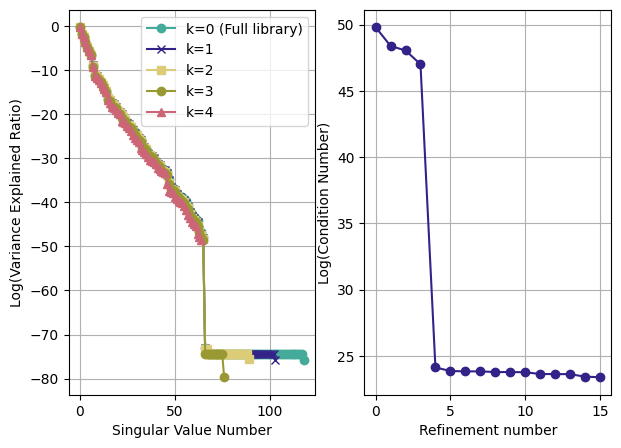

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 5))

# Plot the log of the explained variance ratio for all libraries in the first subplot
ax1.plot(np.log(explained_variance_ratio_full), marker='o', label='k=0 (Full library)', color="#44AA99")
ax1.plot(np.log(explained_variance_ratio_refined_1), marker='x', label='k=1', color="#332288")
ax1.plot(np.log(explained_variance_ratio_refined_2), marker='s', label='k=2', color="#DDCC77")
ax1.plot(np.log(explained_variance_ratio_refined_3), marker='o', label='k=3', color="#999933")
ax1.plot(np.log(explained_variance_ratio_refined_4), marker='^', label='k=4', color="#CC6677")

ax1.set_xlabel('Singular Value Number')
ax1.set_ylabel('Log(Variance Explained Ratio)')
# ax1.set_title('Log(Variance Explained Ratio) vs Singular Value Number')
ax1.legend()
ax1.grid(True)

# Plot the log of condition numbers in the second subplot
ax2.plot(np.log(cond_numbers), marker='o', color="#332288")
ax2.set_ylabel('Log(Condition Number)')
ax2.set_xlabel('Refinement number')
# ax2.set_title('Log of Condition Numbers for Candidate and Refined Libraries')
ax2.grid(True)

### Discovery of Dynamic Relationships + Parameter Estimation

In [144]:
# 1) dF/dt
features_to_remove, refined_candid_lib = get_refined_lib({E4, E2, E3, E1, BE2*BE3, D*DE4, C*CE2, C*BE2, D*BE3, D*CE2,}, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)

refined_candid_lib['d(F) /dt'] = data_matrix_df_smooth_appended['d(F) /dt']
algebraic_model_th.fit(X=refined_candid_lib, scale_columns= True)
best_model = algebraic_model_th.best_models()['d(F) /dt']

best_rhs = best_model.to_frame().index[best_model.to_frame().iloc[:, 0] != 0][:-1].to_list()
best_relationship = best_rhs
print(best_relationship)

Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 5 iterations
Sequential threshold converged in 5 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 4 iterations
Sequential th

In [145]:
lin_model = LinearRegression()

best_relation_lhs = 'd(F) /dt'
best_relation_rhs = [i for i in best_relationship if i != 'd(F) /dt']

lin_model.fit(refined_candid_lib[best_relation_rhs], refined_candid_lib[best_relation_lhs])

d_F = dict(zip(lin_model.feature_names_in_, lin_model.coef_))
d_F = {k: v for k, v in d_F.items() if abs(v) >= 0.1} # filter out small pars

d_F['LHS'] = best_relation_lhs
d_F['intercept'] = lin_model.intercept_ if abs(lin_model.intercept_) >= 0.1 else 0.

In [146]:
d_F

{'A': np.float64(-0.23170178743921327),
 'C': np.float64(-0.14462569953361507),
 'D': np.float64(-0.9397565171915038),
 'AE1': np.float64(2.0324481207668272),
 'BE2': np.float64(46.716652780629154),
 'CE2': np.float64(20.252483811377804),
 'BE3': np.float64(-29.656980873507386),
 'DE4': np.float64(282.33874066239423),
 'A C': np.float64(-0.38011963705176444),
 'A D': np.float64(0.3527453153508947),
 'A F': np.float64(0.3931889061497645),
 'A AE1': np.float64(0.27365634908468095),
 'A CE2': np.float64(-57.8108093111503),
 'A BE3': np.float64(-7.724241500046025),
 'B AE1': np.float64(1.1173753196199334),
 'B BE2': np.float64(20.823548829115552),
 'B CE2': np.float64(-5.060812437642281),
 'B BE3': np.float64(-14.511515817360067),
 'B DE4': np.float64(-11.337631225036127),
 'C^2': np.float64(0.2663559501622501),
 'C D': np.float64(-0.4635685143702215),
 'C F': np.float64(-0.3037131735477132),
 'C AE1': np.float64(87.04837376101878),
 'C BE3': np.float64(-4.400926135268996),
 'C DE4': np.fl

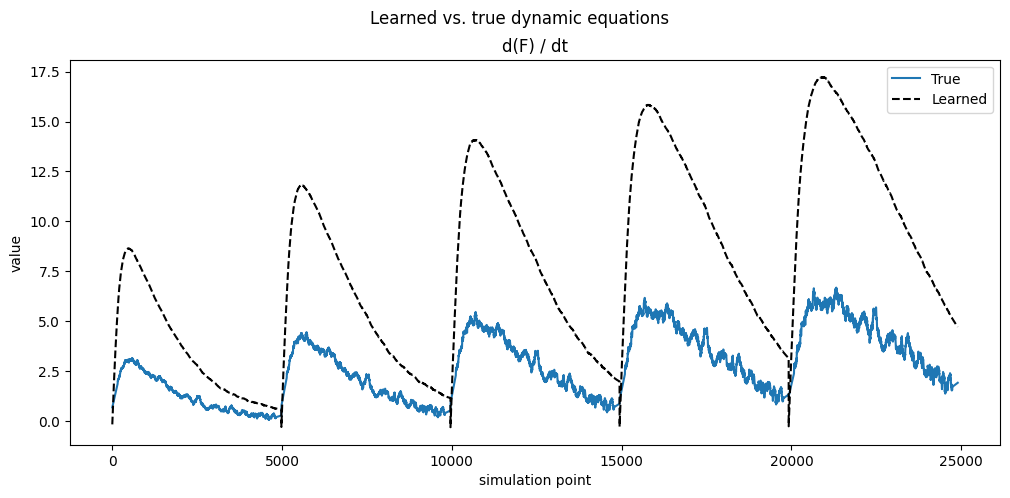

In [147]:
fig, axes = plt.subplots(1, 1, figsize=(12, 5), sharey=False)
DE4_ = data_matrix_df_smooth_appended['DE4']
dF_ = data_matrix_df_smooth_appended['d(F) /dt']

axes.plot(dF_, label='True')

if d_F['LHS'] == 'DE4':
    axes.plot((1/d_F['d(F) /dt'])*DE4_, '--', color='black', label='Learned')
else:
    axes.plot(d_F['DE4']*DE4_, '--', color='black', label='Learned')

axes.set_title("d(F) / dt")
axes.legend()

axes.set_xlabel("simulation point")
axes.set_ylabel("value")

# Shared title
fig.suptitle("Learned vs. true dynamic equations")

# Show the plot
plt.show()